In [1]:
!pip install pretrainedmodels
!pip install albumentations

In [2]:
import torch 
import torch.nn as nn

def dice_loss(preds, trues, weight=None, is_average=True, eps=1):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = 2. * (intersection + eps) / (preds.sum(1) + trues.sum(1) + eps)

    if is_average:
        score = scores.sum() / num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

    
def jaccard_loss(preds, trues, weight=None, is_average=True, eps=1e-3):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = (intersection + eps) / ((preds + trues).sum(1) - intersection + eps)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores


def dice_clamp(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)


def jaccard_clamp(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard_loss(preds, trues, is_average=is_average)    


class FocalLossBinary(nn.Module):
    """Focal loss puts more weight on more complicated examples.
    https://github.com/warmspringwinds/pytorch-segmentation-detection/blob/master/pytorch_segmentation_detection/losses.py
    output is log_softmax
    """

    def __init__(self, gamma=2, size_average=True, reduce=True):
        super(FocalLossBinary, self).__init__(size_average=size_average, reduce=reduce)
        self.gamma = gamma

    def forward(self, outputs, targets):

        outputs = F.logsigmoid(outputs)
        logpt = -F.binary_cross_entropy_with_logits(outputs, targets.float(), reduce=False)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1 - pt).pow(self.gamma)) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

        
class DiceLoss(nn.Module):
    def __init__(self, size_average=True, eps=1):
        super().__init__()
        self.size_average = size_average
        self.eps = eps

    def forward(self, input, target, weight=None):
        return 1-dice_loss(torch.sigmoid(input), target, 
                           weight=weight, is_average=self.size_average, eps=self.eps)


class BCEDiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.dice = DiceLoss(size_average=size_average)

    def forward(self, input, target, weight=None):
        return nn.modules.loss.BCEWithLogitsLoss(size_average=self.size_average, 
                                                 weight=weight)(input, target) + self.dice(input, target, weight=weight)
    
class JaccardLoss(nn.Module):
    def __init__(self, size_average=True, eps=100):
        super().__init__()
        self.size_average = size_average
        self.eps = eps

    def forward(self, input, target, weight=None):
        return 1-jaccard_loss(torch.sigmoid(input), target, 
                              weight=weight, is_average=self.size_average, eps=self.eps)


class BCEJaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.eps = 100
        self.jaccard = JaccardLoss(size_average=size_average, eps=self.eps)

    def forward(self, input, target, weight=None):
        return nn.modules.loss.BCEWithLogitsLoss(size_average=self.size_average, 
                                                 weight=weight)(input, target) + self.jaccard(input, target, weight=weight)

In [3]:
import torch


def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [4]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from pretrainedmodels import models as pmodels

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)


def unet11(pretrained=False, **kwargs):
    """
    pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
            carvana - all weights are pre-trained on
                Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
    """
    model = UNet11(pretrained=pretrained, **kwargs)

    if pretrained == 'carvana':
        state = torch.load('TernausNet.pt')
        model.load_state_dict(state['model'])
    return model


class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, 
                        mode=self.mode, align_corners=self.align_corners)
        return x


class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class ResNet43Unet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out


class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out


In [5]:
import torch
import torchvision
import os
import cv2
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from torch import nn
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from torch.utils import data

from pathlib import Path
from torch.nn import functional as F
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim.lr_scheduler import MultiStepLR
# import models
# from utils import *
# from loss import *
%matplotlib inline

from albumentations import (ToFloat, 
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose, PadIfNeeded, RandomCrop, Normalize, HorizontalFlip, Resize, VerticalFlip,
    RandomCrop
    
)
import albumentations

In [6]:
directory = 'input'

In [7]:
height_req, width_req = 320, 320
height_orig, width_orig = 320, 240

In [8]:
class DriveDataset(data.Dataset):
    def __init__(self, root_path, file_list, aug = False, mode='train'):
        """ Intialize the dataset
        """
        self.file_list = file_list
        self.root_path = root_path
        self.image_folder = os.path.join(self.root_path, "images")
        self.mask_folder = os.path.join(self.root_path, "masks")
        self.mode = mode
        self.aug = aug
        self.pad = PadIfNeeded(p=1, 
                               min_height=height_req, 
                               min_width=width_req, 
                               border_mode=cv2.BORDER_CONSTANT)
        if self.aug:
            self.transform = Compose([
                                RandomRotate90(),
                                Transpose(),
                                Flip()
                            ])
        else:
            self.transform = transforms.ToTensor()
            
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image_path = os.path.join(self.image_folder, self.file_list[index] + ".jpg")
        mask_path  = os.path.join(self.mask_folder,  self.file_list[index] + ".png")

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        pad = self.pad(image=image)
        image = pad['image']


        if self.mode == 'train':
            mask = cv2.imread(mask_path, 0)
            pad = self.pad(image=mask)
            mask = pad['image']
            
        if self.aug:
            if self.mode == 'train':
                data = {"image": image, "mask": mask}
            else:
                data = {"image": image}
                
            transformed = self.transform(**data)
            
            image = transformed['image'].astype('float32') / 255.
            image = np.transpose(image, (2, 0, 1))
            
            if self.mode == 'train':
                return image, transformed['mask'][np.newaxis, :, :].astype('float32') / 255.
            else:
                return image
        else:
            if self.mode == 'train':
                return self.transform(image), mask[np.newaxis, :, :].astype('float32') / 255.
            return self.transform(image)
        
    def __len__(self):
        return len(self.file_list)

In [9]:
train_path = os.path.join(directory, 'train')
file_list = [f.split(os.path.sep)[-1].split('.')[0] for f in sorted(glob.glob(os.path.join(train_path,'images','*jpg')))]

In [10]:
file_list

['1',
 '10',
 '100',
 '1000',
 '1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1006',
 '1007',
 '1008',
 '1009',
 '101',
 '1010',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '102',
 '1020',
 '1021',
 '1022',
 '1023',
 '1024',
 '1025',
 '1026',
 '1027',
 '1028',
 '1029',
 '103',
 '1030',
 '1031',
 '1032',
 '1033',
 '1034',
 '1035',
 '1036',
 '1037',
 '1038',
 '1039',
 '104',
 '1040',
 '1041',
 '1042',
 '1043',
 '1044',
 '1045',
 '1046',
 '1047',
 '1048',
 '1049',
 '105',
 '1050',
 '1051',
 '1052',
 '1053',
 '1054',
 '1055',
 '1056',
 '1057',
 '1058',
 '1059',
 '106',
 '1060',
 '1061',
 '1062',
 '1063',
 '1064',
 '1065',
 '1066',
 '1067',
 '1068',
 '1069',
 '107',
 '1070',
 '1071',
 '1072',
 '1073',
 '1074',
 '1075',
 '1076',
 '1077',
 '1078',
 '1079',
 '108',
 '1080',
 '1081',
 '1082',
 '1083',
 '1084',
 '1085',
 '1086',
 '1087',
 '1088',
 '1089',
 '109',
 '1090',
 '1091',
 '1092',
 '1093',
 '1094',
 '1095',
 '1096',
 '1097',
 '1098',
 '1099',
 '11',


In [11]:
file_list_val = file_list[::10]
file_list_train = [f for f in file_list if f not in file_list_val]

dataset_train = DriveDataset(train_path, file_list_train, aug=True)
dataset_val = DriveDataset(train_path, file_list_val, aug=False)

In [12]:
image, mask = next(iter(data.DataLoader(dataset_train, batch_size=1, shuffle=True)))  

In [13]:
image

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [14]:
image.shape

torch.Size([1, 3, 320, 320])

torch.Size([1, 1, 320, 320])


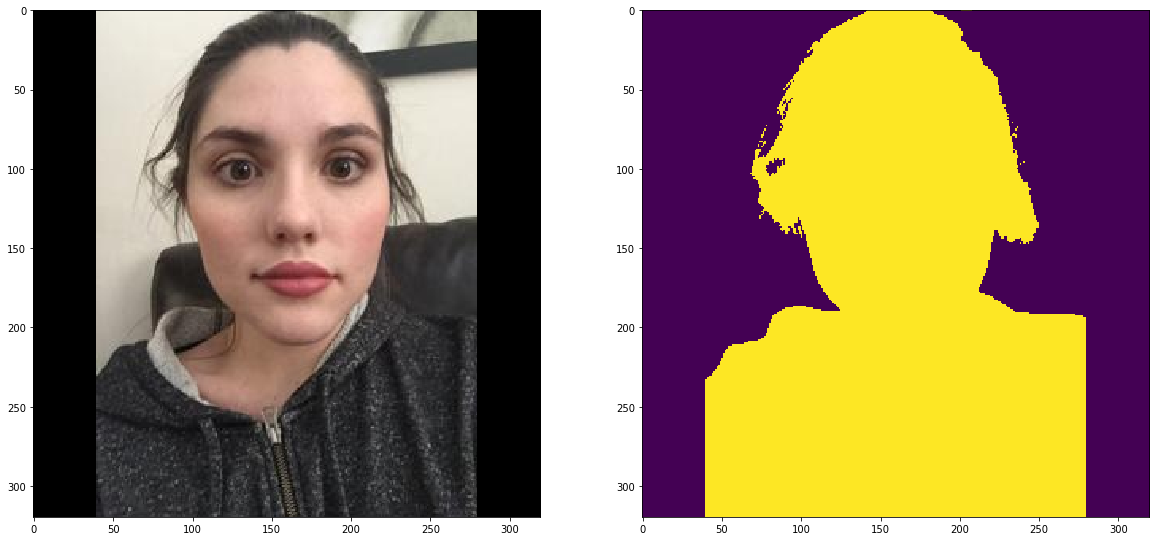

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image.data.numpy().squeeze().transpose((1,2,0)))
plt.subplot(1, 2, 2)
plt.imshow(mask.data.numpy().squeeze())
print(mask.shape)

In [16]:
mask.data.numpy().squeeze().shape

(320, 320)

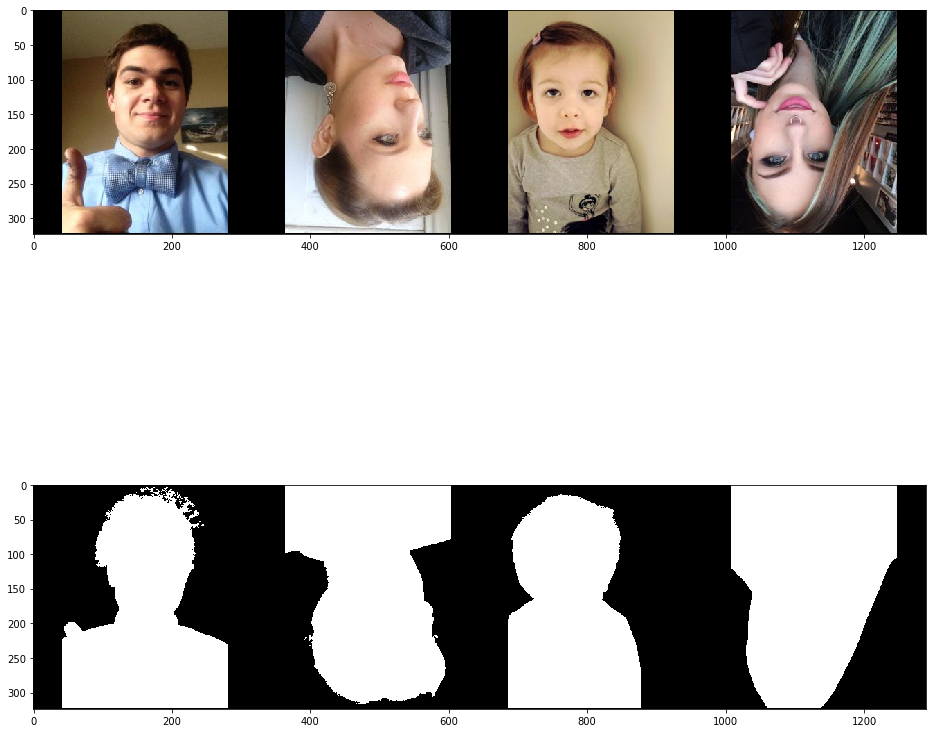

In [17]:
images, masks = next(iter(data.DataLoader(dataset_train, batch_size = 4)))

plt.figure(figsize=(16,16))
plt.subplot(211)
plt.imshow(torchvision.utils.make_grid(images).data.numpy().transpose((1,2,0)))
plt.subplot(212)
plt.imshow(torchvision.utils.make_grid(masks).data.numpy().transpose((1,2,0)))

In [18]:
import time

In [19]:
experiment_name = "base_BCEDiceLoss_bgBatch_"

In [20]:
model = ResNet43Unet().cuda()

epoch = 150
learning_rate = 3e-4

loss_fn = BCEDiceLoss()#torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loader_train = data.DataLoader(dataset_train, 
                               batch_size=8, 
                               shuffle=True)

loader_val   = data.DataLoader(dataset_val, 
                               batch_size=8, 
                               shuffle=False)

load_checkpoint('base_BCEDiceLoss_continue1_drive-25.pth',model,optimizer)

start_time = int(time.time())
for e in range(epoch):    
    train_loss = []
    train_dice = []
    train_jaccard = []

    for image, mask in loader_train:
        image, mask = image.cuda(), mask.cuda()
        
        optimizer.zero_grad()
        y_pred = model(image)

        loss = loss_fn(y_pred, mask)
        dice = dice_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        jaccard = jaccard_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        loss.backward()

        optimizer.step()
        
        train_loss.append(loss.item())
        train_dice.append(dice.item())
        train_jaccard.append(jaccard.item())

        
    val_loss = []
    val_dice = []
    val_jaccard = []
    for image, mask in loader_val:
        image, mask = image.cuda(), mask.cuda()
        y_pred = model(image)

        loss = loss_fn(y_pred, mask)
        dice = dice_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        jaccard = jaccard_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        
        val_loss.append(loss.item())
        val_dice.append(dice.item())
        val_jaccard.append(jaccard.item())
        
    print("epoch: %d, time: %d, train_loss: %.3f, train_dice: %.3f, train_jaccard: %.3f, val_loss: %.3f, val_dice: %.3f, val_jaccard: %.3f" % 
          (e, int(time.time())-start_time, np.mean(train_loss),np.mean(train_dice),np.mean(train_jaccard), 
              np.mean(val_loss),np.mean(val_dice),np.mean(val_jaccard)))
    if(e%25==0):
        save_checkpoint(experiment_name+'drive-%i.pth' % e, model, optimizer)
save_checkpoint(experiment_name+'drive-%i.pth' % epoch, model, optimizer)

model loaded from base_BCEDiceLoss_continue1_drive-25.pth


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch: 0, time: 65, train_loss: 0.094, train_dice: 0.974, train_jaccard: 0.950, val_loss: 0.133, val_dice: 0.959, val_jaccard: 0.926
model saved to base_BCEDiceLoss_bgBatch_drive-0.pth
epoch: 1, time: 132, train_loss: 0.090, train_dice: 0.975, train_jaccard: 0.952, val_loss: 0.147, val_dice: 0.957, val_jaccard: 0.923
epoch: 2, time: 199, train_loss: 0.088, train_dice: 0.975, train_jaccard: 0.953, val_loss: 0.151, val_dice: 0.954, val_jaccard: 0.920


KeyboardInterrupt: 

In [43]:
test_path = os.path.join(directory, 'test')
test_file_list = glob.glob(os.path.join(test_path, 'images', '*.jpg'))
test_file_list = [f.split(os.sep)[-1].split('.')[0] for f in test_file_list]
print('First 3 names of test files:', test_file_list[:3])

First 3 names of test files: ['1492', '1493', '1494']


In [44]:
print(f"Test size: {len(test_file_list)}")
test_dataset = DriveDataset(test_path, test_file_list, mode=None)
all_images = []
all_predictions = []
for image in tqdm_notebook(data.DataLoader(test_dataset, batch_size = 2)):
    image = image.cuda()
#     print(image.shape)
    all_images.append(image.cpu().data.numpy())
    y_pred = torch.sigmoid(model(image)).cpu().data.numpy()
    all_predictions.append(y_pred)
all_predictions_stacked = np.vstack(all_predictions)[:, 0, :, :]
all_images = np.vstack(all_images)[:, :, :, :]

Test size: 2177


torch.Size([1, 1, 320, 320])


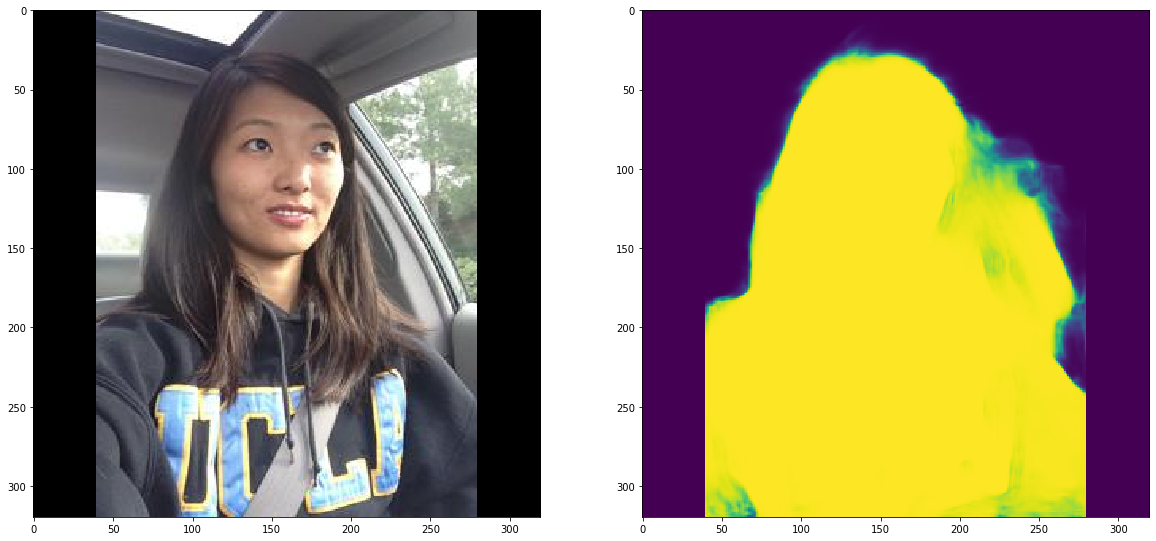

In [45]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(all_images[0].transpose(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(all_predictions_stacked[0])
print(mask.shape)

torch.Size([1, 1, 320, 320])


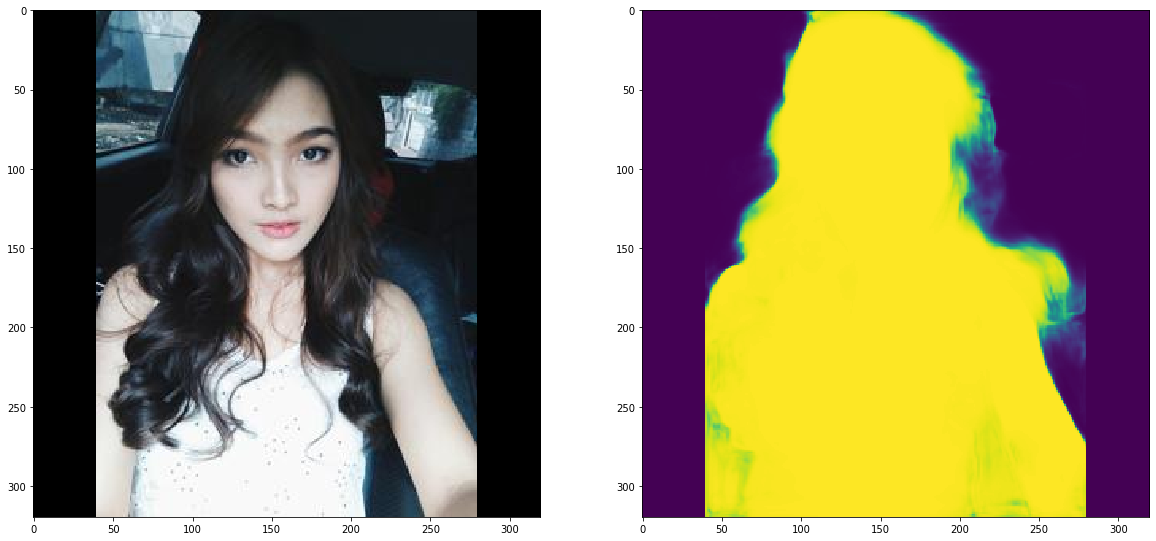

In [46]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(all_images[1].transpose(1,2,0))
plt.subplot(1, 2, 2)
plt.imshow(all_predictions_stacked[1])
print(mask.shape)